In [1]:
from act4brd.graph import create_street_grid
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors as mcolors
import random
import numpy as np
import cvxpy as cp

C:\Users\diego\AppData\Local\Temp\ipykernel_28100\4243742239.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


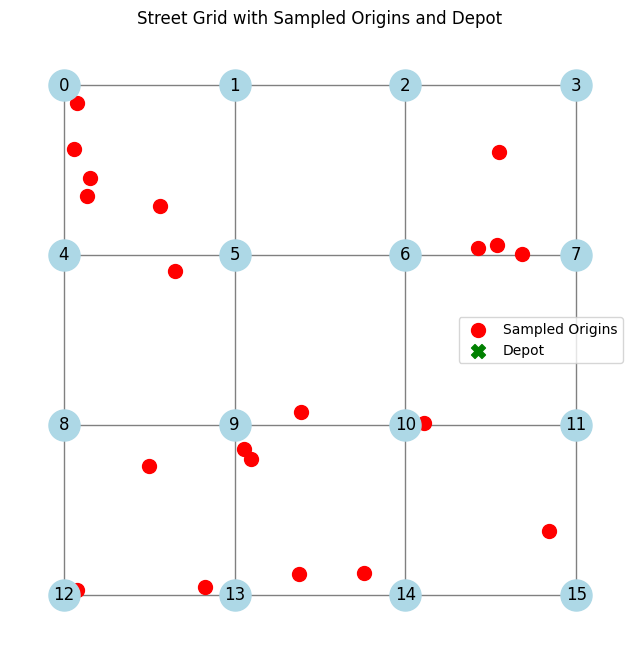

In [2]:
g, pos = create_street_grid(4,4)
depot = list(g.nodes)[0]
# Randomly sample 20 points in the 2D space [min(p[0]), max(p[0])] x [min(p[1]), max(p[1])] for p in pos.values()
origins = []

x_values = [p[0] for p in pos.values()]
y_values = [p[1] for p in pos.values()]
for _ in range(20):
    x = random.uniform(min(x_values), max(x_values))
    y = random.uniform(min(y_values), max(y_values))
    origins.append((x,y))

# Visualize the graph and sampled points
fig, ax = plt.subplots(figsize=(8,8))
nx.draw(g, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, ax=ax)
ax.scatter(*zip(*origins), color='red', s=100, label='Sampled Origins')
ax.scatter(pos[depot][0], pos[depot][1], color='green', s=100, label='Depot', marker='X')
ax.legend()
ax.set_title('Street Grid with Sampled Origins and Depot')
fig.show()

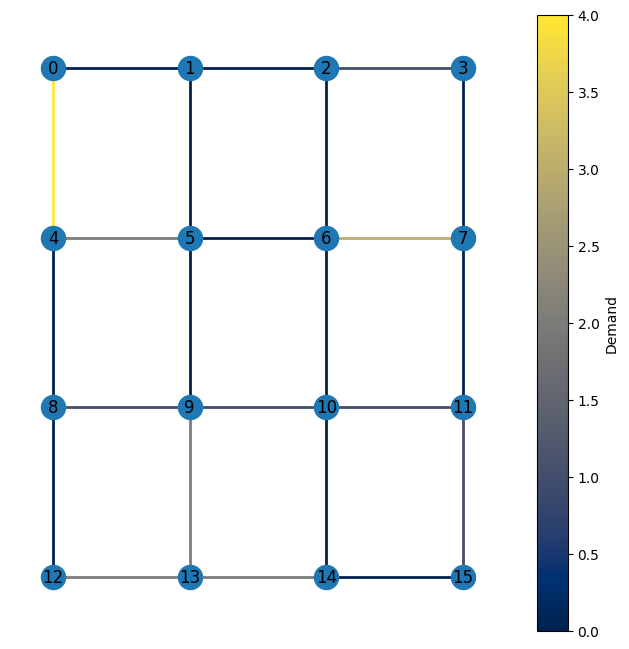

In [3]:
# For each origin, find the nearest edge in the graph
def nearest_edge(g, pos, point):
    min_dist = float('inf')
    nearest = None
    for u, v in g.edges():
        p1 = np.array(pos[u])
        p2 = np.array(pos[v])
        p0 = np.array(point)
        # Compute distance from point to line segment p1-p2
        line_vec = p2 - p1
        p1_to_p0 = p0 - p1
        line_len = np.dot(line_vec, line_vec)
        if line_len == 0:
            dist = np.linalg.norm(p0 - p1)
        else:
            t = max(0, min(1, np.dot(p1_to_p0, line_vec) / line_len))
            projection = p1 + t * line_vec
            dist = np.linalg.norm(p0 - projection)
        if dist < min_dist:
            min_dist = dist
            nearest = (u, v)
    return nearest

# For each edge in the graph, add an attribute 'demand' that counts how many origins are nearest to that edge
for u, v in g.edges():
    g.edges[u, v]['demand'] = 0

for origin in origins:
    edge = nearest_edge(g, pos, origin)
    if edge is None:
        # No edge found (should not occur with a non-empty graph); skip to be safe
        continue
    g.edges[edge]['demand'] += 1

# Check if total demand matches number of origins
total_demand = sum(g.edges[u, v]['demand'] for u, v in g.edges())
assert total_demand == len(origins), "Total demand does not match number of origins"

# Visualize the graph with edges colored by demand
cmap_name = 'cividis'  # choose any valid Matplotlib colormap (e.g., 'viridis', 'plasma', 'inferno')
cmap = plt.get_cmap(cmap_name)

# Gather demands in a consistent edge order
edges = list(g.edges())
demands = [g.edges[u, v]['demand'] for u, v in edges]

if demands:
    vmin = min(demands)
    vmax = max(demands)
else:
    vmin, vmax = 0, 1

# Normalize and map to colors
norm = mcolors.Normalize(vmin=vmin, vmax=vmax if vmax > vmin else vmin + 1)
edge_colors = [cmap(norm(d)) for d in demands]

# Draw on an explicit Axes so we can attach a colorbar
fig, ax = plt.subplots(figsize=(8,8))
nx.draw(g, pos=pos, with_labels=True, edge_color=edge_colors, width=2, ax=ax)

# Optional colorbar for reference
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Demand')

In [4]:
# Define the available fleet of vehicles with increased capacity and range
fleet = {
    'bus_1': {
        'capacity': 100,
        'range': 200,
    },
}

In [5]:
# Linear program formulation of the Capacitated Arc Routing Problem (CARP)

# 0) Fix the origin node id, let's call it "depot" for now
depot = 0

# 1) Required edges: those with demand > 0
required_edges = []
for (u, v, data) in g.edges(data=True):
    d = int(data.get('demand', 0))
    if d > 0:
        required_edges.append((u, v))

# 3) Precompute all-pairs shortest-path distances on the graph
#    w.r.t. 'length' (deadheading distances)
sp_len = dict(nx.all_pairs_dijkstra_path_length(g, weight='length'))

# 4) Build oriented tasks for CARP
# Each required edge e=(u,v) yields two tasks:
#   t1: start=u, end=v  and  t2: start=v, end=u
tasks = []  # list of dicts with keys: edge, start, end, demand, service_cost
edge_to_task_ids = {}  # map edge index -> (t_id1, t_id2)

for e_idx, (u, v) in enumerate(required_edges):
    q = int(g.edges[u, v]['demand'])
    s = g.edges[u, v]['length']
    t1 = {"edge": (u, v), "start": u, "end": v, "demand": q, "service_cost": s, "edge_index": e_idx, "orient": "u->v"}
    t2 = {"edge": (u, v), "start": v, "end": u, "demand": q, "service_cost": s, "edge_index": e_idx, "orient": "v->u"}
    tasks.append(t1); id1 = len(tasks)
    tasks.append(t2); id2 = len(tasks)
    edge_to_task_ids[e_idx] = (id1, id2)

M = len(tasks)  # number of oriented tasks
K = len(fleet)  # number of vehicles

vehicles = list(fleet.keys())
cap = np.array([fleet[k]["capacity"] for k in vehicles], dtype=float)
rng = np.array([fleet[k]["range"]    for k in vehicles], dtype=float)

# 5) Build distance matrix W (size (M+1)x(M+1)), index 0 is depot
#    W[i,j] = deadheading distance from end(i) to start(j); W[0,j] from depot to start(j);
#    W[i,0] from end(i) to depot; W[0,0]=0 (unused)
W = np.zeros((M+1, M+1), dtype=float)
start_nodes = [None] + [t["start"] for t in tasks]  # 1..M
end_nodes   = [None] + [t["end"]   for t in tasks]  # 1..M

for j in range(1, M+1):
    W[0, j] = sp_len[depot][start_nodes[j]]
for i in range(1, M+1):
    W[i, 0] = sp_len[end_nodes[i]][depot]
    for j in range(1, M+1):
        if i != j:
            W[i, j] = sp_len[end_nodes[i]][start_nodes[j]]

# 6) Service costs and demands per task (length of serviced edge, full demand)
service_cost = np.zeros(M+1, dtype=float)  # index 0 (depot) unused
task_demand  = np.zeros(M+1, dtype=float)
for i in range(1, M+1):
    service_cost[i] = tasks[i-1]["service_cost"]
    task_demand[i]  = tasks[i-1]["demand"]

# ---------- Decision variables ----------
# x[i,j,k] = 1 if vehicle k travels from i to j (i,j in {0..M}, i != j)
x = cp.Variable((M+1, M+1, K), boolean=True)

# z[i,k] = 1 if vehicle k serves oriented task i; z[0,k] indicates vehicle k is used
z = cp.Variable((M+1, K), boolean=True)

# u[i,k] = load after serving task i (only meaningful for i>=1); u[0,k]=0
u = cp.Variable((M+1, K))

cons = []

# No self arcs
for k in range(K):
    cons += [cp.diag(x[:, :, k]) == 0]

# Flow conservation at tasks
for k in range(K):
    for i in range(1, M+1):
        cons += [cp.sum(x[i, :, k]) == z[i, k]]  # one outgoing if task served by k
        cons += [cp.sum(x[:, i, k]) == z[i, k]]  # one incoming if task served by k

# Depot usage: at most one tour per bus (model decides whether to use it)
for k in range(K):
    cons += [cp.sum(x[0, :, k]) == z[0, k]]  # leave depot if used
    cons += [cp.sum(x[:, 0, k]) == z[0, k]]  # return to depot if used
    # if bus unused, it cannot serve tasks; if used, it may serve any number
    cons += [cp.sum(z[1:, k]) <= M * z[0, k]]

# Serve each required edge exactly once (pick exactly one orientation, across all buses)
for e_idx, (t1, t2) in edge_to_task_ids.items():
    cons += [cp.sum(z[[t1, t2], :]) == 1]

# Capacity constraints (simplified - just enforce bounds)
for k in range(K):
    Qk = cap[k]
    cons += [u[0, k] == 0]  # depot load is zero
    for i in range(1, M+1):
        # Bind u to z: if task i is served by k, load must equal demand
        cons += [u[i, k] >= task_demand[i] * z[i, k]]
        cons += [u[i, k] <= Qk * z[i, k]]
    
    # Load propagation: if arc (i,j) is used, load increases
    for i in range(0, M+1):
        for j in range(1, M+1):
            if i == j:
                continue
            # If x[i,j,k]=1, then u[j,k] >= u[i,k] + demand[j]
            cons += [u[j, k] >= u[i, k] + task_demand[j] - Qk * (1 - x[i, j, k])]

# Range (distance budget): deadhead (W * x) + service (edge lengths) must fit
for k in range(K):
    deadhead = cp.sum(cp.multiply(W, x[:, :, k]))
    service  = cp.sum(cp.multiply(service_cost, z[:, k]))
    cons += [deadhead + service <= rng[k]]

# Objective: minimize total deadhead + service distance
obj = cp.Minimize(cp.sum([cp.sum(cp.multiply(W, x[:, :, k])) +
                          cp.sum(cp.multiply(service_cost, z[:, k]))
                          for k in range(K)]))

# ---------- Solve ----------
prob = cp.Problem(obj, cons)
print("Solving MILP")
try:
    # Try with verbose to see progress; set a reasonable time limit
    prob.solve(solver=cp.GLPK_MI, verbose=True, glpk={'msg_lev': 'GLP_MSG_ON', 'tm_lim': 2*60*1000})  # 2-min limit
except Exception as e:
    print(f"⚠️  GLPK_MI failed or unavailable: {e}")
    print("Trying CBC as fallback...")
    try:
        prob.solve(solver=cp.CBC, verbose=True, maximumSeconds=120)
    except Exception as e2:
        print(f"⚠️  CBC also failed: {e2}")
        print("Trying default solver...")
        prob.solve(verbose=True)

print()
print("Status:", prob.status)
print("Objective (total distance):", prob.value)

# ---------- Decode routes ----------
if prob.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
    print(f"⚠️ Solver did not find a feasible solution (status={prob.status}).")
    print("Possible causes:")
    print("  • Range or capacity too tight for the demand distribution.")
    print("  • Problem may be too large for the solver (try reducing grid size).")
    print("  • Try increasing fleet 'range' or 'capacity' in the fleet dict.")
    routes = {vehicles[k]: [("no_solution", prob.status)] for k in range(K)}
else:
    routes = {vehicles[k]: [] for k in range(K)}
    for k in range(K):
        Xk = np.round(x.value[:, :, k]).astype(int)
        if z.value is None:
            continue
        used = int(round(z.value[0, k]))  # 0/1
        if used == 0:
            routes[vehicles[k]] = [("unused_bus_returns_to_depot", depot)]
            continue

        route = [0]  # start at depot node index (0)
        current = 0
        visited = set([0])
        while True:
            nxts = np.where(Xk[current] == 1)[0]
            if len(nxts) == 0:
                break
            nxt = int(nxts[0])
            route.append(nxt)
            if nxt == 0:
                break
            if nxt in visited:  # safety guard
                break
            visited.add(nxt)
            current = nxt

        # Decode each task id to an actual oriented edge with demand & cost
        decoded = []
        cum_load = 0
        for idx in route:
            if idx == 0:
                decoded.append(("depot", depot))
            else:
                t = tasks[idx-1]
                cum_load += t["demand"]
                decoded.append((
                    "serve_edge",
                    t["edge"],
                    t["orient"],
                    {"demand": t["demand"],
                     "service_len": t["service_cost"],
                     "cum_load_after": int(cum_load)}
                ))
        routes[vehicles[k]] = decoded

routes

(CVXPY) Dec 02 11:55:15 PM: Your problem has 575 variables, 611 constraints, and 0 parameters.
(CVXPY) Dec 02 11:55:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 02 11:55:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 02 11:55:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 02 11:55:15 PM: Your problem is compiled with the CPP canonicalization backend.


Solving MILP
                                     CVXPY                                     
                                     v1.7.4                                    


(CVXPY) Dec 02 11:55:15 PM: Compiling problem (target solver=GLPK_MI).
(CVXPY) Dec 02 11:55:15 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> GLPK_MI
(CVXPY) Dec 02 11:55:15 PM: Applying reduction Dcp2Cone
(CVXPY) Dec 02 11:55:16 PM: Applying reduction CvxAttr2Constr
(CVXPY) Dec 02 11:55:16 PM: Applying reduction ConeMatrixStuffing


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


d:\1.044-final\.venv\Lib\site-packages\cvxpy\reductions\solvers\solving_chain_utils.py:41: UserWarning: The problem has an expression with dimension greater than 2. Defaulting to the SCIPY backend for canonicalization.
  warnings.warn(UserWarning(
(CVXPY) Dec 02 11:55:17 PM: Applying reduction GLPK_MI
(CVXPY) Dec 02 11:55:17 PM: Finished problem compilation (took 1.928e+00 seconds).
(CVXPY) Dec 02 11:55:17 PM: Invoking solver GLPK_MI  to obtain a solution.
(CVXPY) Dec 02 11:55:19 PM: Problem status: optimal


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


(CVXPY) Dec 02 11:55:19 PM: Optimal value: 2.000e+01
(CVXPY) Dec 02 11:55:19 PM: Compilation took 1.928e+00 seconds
(CVXPY) Dec 02 11:55:19 PM: Solver (including time spent in interface) took 1.937e+00 seconds



Status: optimal
Objective (total distance): 20.0


{'bus_1': [('depot', 0),
  ('serve_edge',
   (0, 4),
   'u->v',
   {'demand': 4, 'service_len': 1, 'cum_load_after': 4}),
  ('serve_edge',
   (4, 5),
   'u->v',
   {'demand': 2, 'service_len': 1, 'cum_load_after': 6}),
  ('serve_edge',
   (9, 13),
   'u->v',
   {'demand': 2, 'service_len': 1, 'cum_load_after': 8}),
  ('serve_edge',
   (13, 14),
   'v->u',
   {'demand': 2, 'service_len': 1, 'cum_load_after': 10}),
  ('serve_edge',
   (12, 13),
   'v->u',
   {'demand': 2, 'service_len': 1, 'cum_load_after': 12}),
  ('serve_edge',
   (8, 9),
   'u->v',
   {'demand': 1, 'service_len': 1, 'cum_load_after': 13}),
  ('serve_edge',
   (9, 10),
   'u->v',
   {'demand': 1, 'service_len': 1, 'cum_load_after': 14}),
  ('serve_edge',
   (11, 15),
   'u->v',
   {'demand': 1, 'service_len': 1, 'cum_load_after': 15}),
  ('serve_edge',
   (10, 11),
   'v->u',
   {'demand': 1, 'service_len': 1, 'cum_load_after': 16}),
  ('serve_edge',
   (6, 7),
   'u->v',
   {'demand': 3, 'service_len': 1, 'cum_load_af

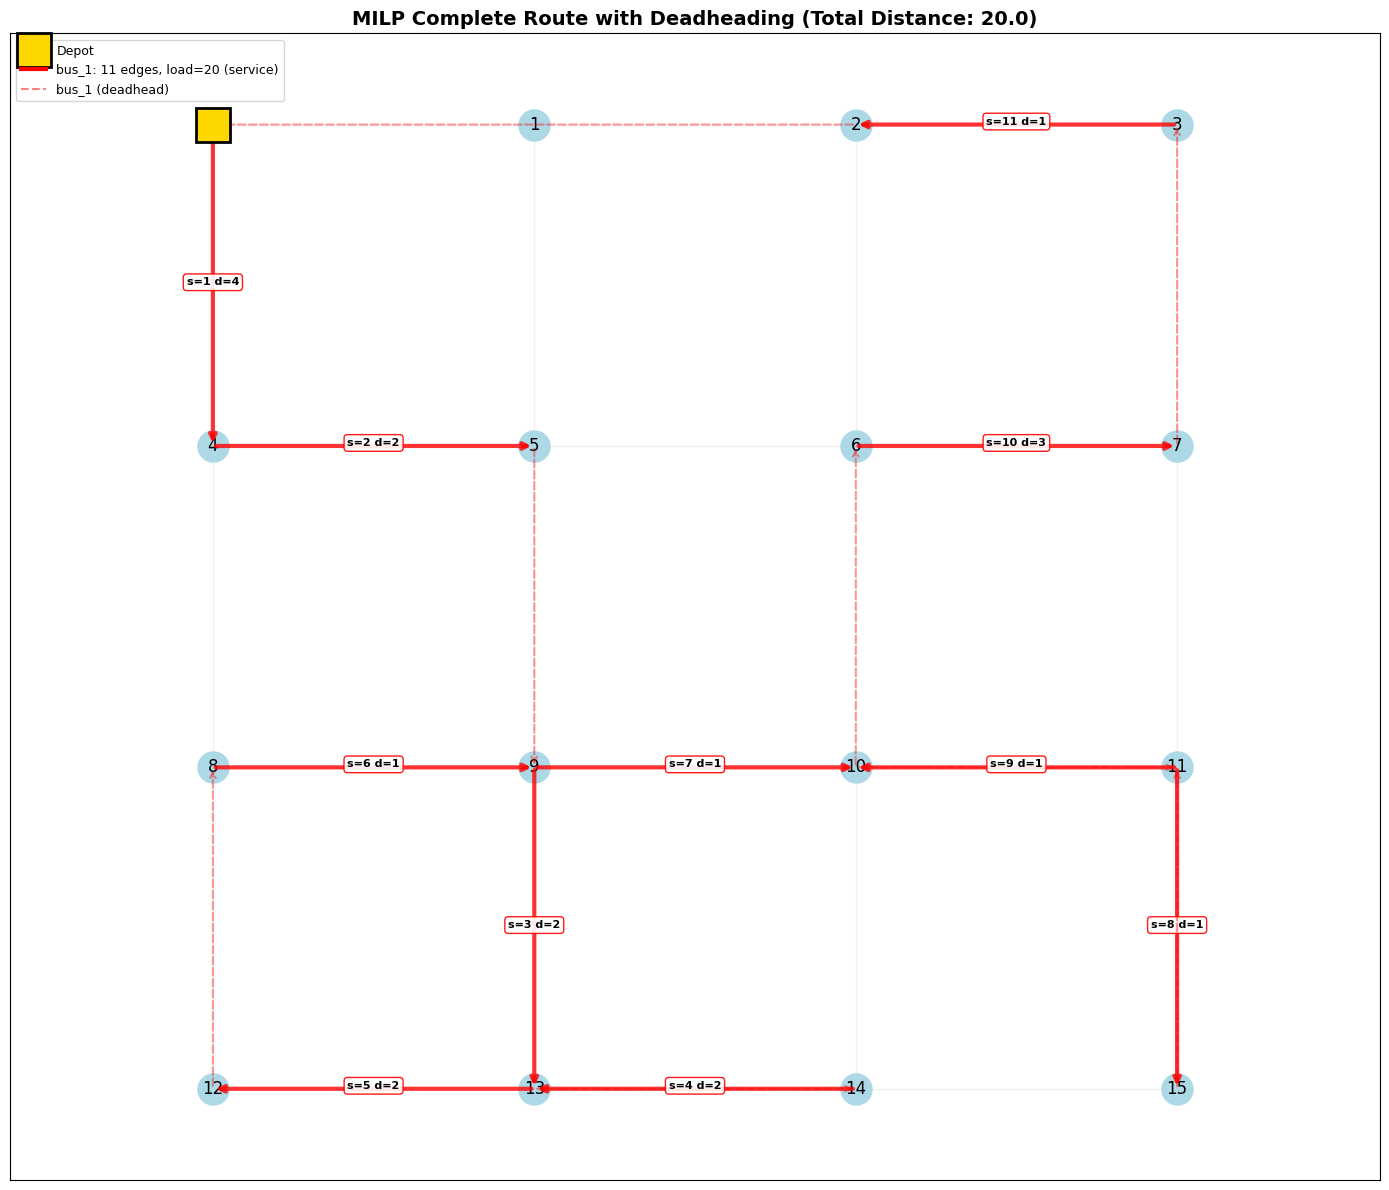

In [6]:
# Visualize COMPLETE route with deadheading
fig, ax = plt.subplots(figsize=(14, 12))

# Draw base graph
nx.draw_networkx_nodes(g, pos, node_color='lightblue', node_size=500, ax=ax)
nx.draw_networkx_labels(g, pos, ax=ax)
nx.draw_networkx_edges(g, pos, edge_color='lightgray', width=1, alpha=0.3, ax=ax)

# Color scheme for vehicles
vehicle_colors_milp = ['red', 'blue', 'green', 'orange', 'purple']
vehicle_labels = []

# Draw each vehicle's complete route
for bus_idx, (bus_name, route) in enumerate(routes.items()):
    color = vehicle_colors_milp[bus_idx % len(vehicle_colors_milp)]
    
    # Build sequence of nodes visited
    node_sequence = []
    for step in route:
        if step[0] == 'depot':
            node_sequence.append(step[1])  # depot node
        elif step[0] == 'serve_edge':
            edge = step[1]
            orientation = step[2]
            # Add the ending node of the service (we're at the start already from previous step)
            if orientation == 'u->v':
                # If sequence is empty or doesn't end at u, add u first
                if not node_sequence or node_sequence[-1] != edge[0]:
                    node_sequence.append(edge[0])
                node_sequence.append(edge[1])  # end at v
            else:  # v->u
                # If sequence is empty or doesn't end at v, add v first
                if not node_sequence or node_sequence[-1] != edge[1]:
                    node_sequence.append(edge[1])
                node_sequence.append(edge[0])  # end at u
    
    if len(node_sequence) < 2:
        continue
    
    # Draw the complete path with arrows
    for i in range(len(node_sequence) - 1):
        start = node_sequence[i]
        end = node_sequence[i + 1]
        
        # Check if this is a service edge or deadheading
        is_service = False
        edge_demand = 0
        for i, step in enumerate(route):
            if step[0] == 'serve_edge':
                edge = step[1]  # (u, v) tuple
                orientation = step[2]
                # Check if we're traversing this edge in the direction it's being served
                if orientation == 'u->v':
                    # Serving from u to v
                    if edge[0] == start and edge[1] == end:
                        is_service = True
                        edge_demand = g.edges[edge]['demand']
                        break
                else:  # v->u
                    # Serving from v to u
                    if edge[1] == start and edge[0] == end:
                        is_service = True
                        edge_demand = g.edges[edge]['demand']
                        break
        
        # Draw arrow with different style for service vs deadhead
        if is_service:
            # Service edge - solid thick arrow
            ax.annotate('',
                        xy=pos[end], xytext=pos[start],
                        arrowprops=dict(arrowstyle='->', color=color, lw=3, alpha=0.8))
            
            # Add demand label
            mid_x = (pos[start][0] + pos[end][0]) / 2
            mid_y = (pos[start][1] + pos[end][1]) / 2
            ax.text(mid_x, mid_y, f's={i} d={edge_demand}', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                            edgecolor=color, alpha=0.9),
                    fontsize=8, ha='center', fontweight='bold')
        else:
            # Deadhead - dashed thin arrow
            ax.annotate('',
                        xy=pos[end], xytext=pos[start],
                        arrowprops=dict(arrowstyle='->', color=color, lw=1.5, 
                                        alpha=0.4, linestyle='dashed'))
    
    # Count service edges and total demand
    service_count = sum(1 for step in route if step[0] == 'serve_edge')
    total_demand = sum(step[3]['demand'] for step in route if step[0] == 'serve_edge')
    vehicle_labels.append(f'{bus_name}: {service_count} edges, load={total_demand}')

# Draw depot with special marker
ax.plot(pos[depot][0], pos[depot][1], 
        marker='s', markersize=25, color='gold', markeredgecolor='black', 
        markeredgewidth=2, zorder=10, label='Depot')

# Add legend
for i, label in enumerate(vehicle_labels):
    color = vehicle_colors_milp[i % len(vehicle_colors_milp)]
    ax.plot([], [], color=color, linewidth=3, label=label + ' (service)')
    ax.plot([], [], color=color, linewidth=1.5, linestyle='dashed', 
            alpha=0.5, label=label.split(':')[0] + ' (deadhead)')

ax.legend(loc='upper left', fontsize=9)
ax.set_title(f'MILP Complete Route with Deadheading (Total Distance: {prob.value:.1f})', 
            fontsize=14, fontweight='bold')
ax.axis('equal')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()